## Step 1: train_model.ipynb with Trust Score

We now:
1. Generate synthetic normal data.
2. Preprocess (one-hot + scaling).
3. Train IsolationForest.
4. Compute anomaly scores on training set, derive `score_min`, `score_max`.
5. Save scaler, model, and trust parameters for use in `client.py`.

Trust score for a new sample is:  `(score - score_min) / (score_max - score_min)`, clipped to [0,1].


In [1]:
# Imports
import os
import json
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

### Setup directories
Ensure `dataset/` and `models/` exist.

In [2]:
os.makedirs("dataset", exist_ok=True)
os.makedirs("models", exist_ok=True)
print("Directories 'dataset/' and 'models/' are ready.")

Directories 'dataset/' and 'models/' are ready.


### Generate Synthetic Normal Data
Change `n_samples` as needed.

In [3]:
COMMON_PORTS = [80, 443, 22, 8080]

def generate_normal_data_entry():
    return {
        "src_port": random.choice(COMMON_PORTS),
        "dst_port": random.randint(1024, 65535),
        "packet_size": random.randint(100, 1500),
        "duration_ms": random.randint(50, 500),
        "protocol": random.choice(["TCP", "UDP"])
    }

# Number of samples
n_samples = 1000000  # adjust as needed
dataset = [generate_normal_data_entry() for _ in range(n_samples)]

# Save synthetic data
training_data_path = "dataset/training_data.json"
with open(training_data_path, "w") as f:
    json.dump(dataset, f, indent=2)
print(f"Generated {n_samples} synthetic normal samples and saved to {training_data_path}.")

Generated 1000000 synthetic normal samples and saved to dataset/training_data.json.


### Load and Inspect Raw Data

In [4]:
# Load synthetic data
with open("dataset/training_data.json") as f:
    raw_data = json.load(f)
df = pd.DataFrame(raw_data)
print("Raw data sample:")
display(df.head())
print("DataFrame info:")
display(df.info())
print("Descriptive statistics:")
display(df.describe(include='all'))

Raw data sample:


,src_port,dst_port,packet_size,duration_ms,protocol
0,22,4939,855,271,UDP
1,80,35797,470,115,UDP
2,443,54955,1479,211,TCP
3,80,45453,1291,488,TCP
4,22,11415,1304,262,TCP


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   src_port     1000000 non-null  int64 
 1   dst_port     1000000 non-null  int64 
 2   packet_size  1000000 non-null  int64 
 3   duration_ms  1000000 non-null  int64 
 4   protocol     1000000 non-null  object
dtypes: int64(4), object(1)
memory usage: 38.1+ MB


None

Descriptive statistics:


,src_port,dst_port,packet_size,duration_ms,protocol
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,TCP
freq,NaN,NaN,NaN,NaN,500057
mean,2156.646914,33238.782230,800.477724,274.902100,NaN
std,3424.005221,18628.749684,404.777778,130.128696,NaN
min,22.000000,1024.000000,100.000000,50.000000,NaN
25%,22.000000,17094.000000,450.000000,162.000000,NaN
50%,443.000000,33230.000000,800.000000,275.000000,NaN
75%,8080.000000,49370.000000,1151.000000,387.000000,NaN


### Preprocessing Function (One-hot)
We will later scale.


In [5]:
def preprocess_onehot(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    if 'protocol' in df_copy.columns:
        df_encoded = pd.get_dummies(df_copy, columns=['protocol'], drop_first=True)
    else:
        df_encoded = df_copy
    # Ensure expected columns exist
    expected = ['src_port','dst_port','packet_size','duration_ms']
    # After one-hot, columns might include 'protocol_UDP'
    if 'protocol_UDP' in df_encoded.columns:
        expected.append('protocol_UDP')
    else:
        # If protocol column absent, still add protocol_UDP=0
        df_encoded['protocol_UDP'] = 0
        expected.append('protocol_UDP')
    # Some columns might be in different order; select these
    df_encoded = df_encoded[expected]
    return df_encoded

### Preprocess & Scale Dataset
- One-hot then standard-scale.

In [6]:
# Preprocess one-hot
df_encoded = preprocess_onehot(df)
print("After one-hot, sample:")
display(df_encoded.head())

# Fit scaler
scaler = StandardScaler()
X = df_encoded.values  # numpy array
X_scaled = scaler.fit_transform(X)
print("Scaled feature shape:", X_scaled.shape)
# Optionally inspect mean/var
print("Scaler mean (first 5):", scaler.mean_[:5])
print("Scaler var (first 5):", scaler.var_[:5])

After one-hot, sample:


,src_port,dst_port,packet_size,duration_ms,protocol_UDP
0,22,4939,855,271,True
1,80,35797,470,115,True
2,443,54955,1479,211,False
3,80,45453,1291,488,False
4,22,11415,1304,262,False


Scaled feature shape: (1000000, 5)
Scaler mean (first 5): [2.15664691e+03 3.32387822e+04 8.00477724e+02 2.74902100e+02
 4.99943000e-01]
Scaler var (first 5): [1.17238000e+07 3.47029968e+08 1.63844886e+05 1.69334606e+04
 2.49999997e-01]


### Train Isolation Forest on Scaled Data

In [7]:
model = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)
model.fit(X_scaled)
print("Isolation Forest trained on scaled synthetic normal data.")

Isolation Forest trained on scaled synthetic normal data.


### Compute Trust Parameters from Training Set
Decision function returns anomaly score: higher = more normal. We record min and max from training.


Training anomaly score min: -0.047540, max: 0.153559


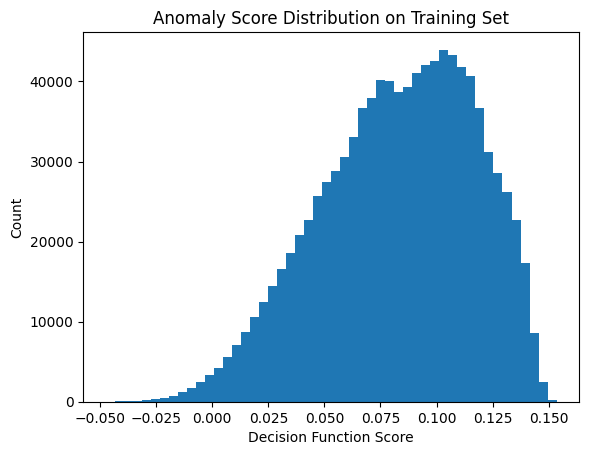

In [8]:
# Compute anomaly scores on training set
scores_train = model.decision_function(X_scaled)  # shape (n_samples,)
score_min = float(np.min(scores_train))
score_max = float(np.max(scores_train))
print(f"Training anomaly score min: {score_min:.6f}, max: {score_max:.6f}")
# Optionally inspect distribution
import matplotlib.pyplot as plt
plt.hist(scores_train, bins=50)
plt.title('Anomaly Score Distribution on Training Set')
plt.xlabel('Decision Function Score')
plt.ylabel('Count')
plt.show()

### Sanity Check on Training Set
How many flagged anomalies (~1% expected):

In [9]:
preds_train = model.predict(X_scaled)  # 1 normal, -1 anomaly
n_anomalies = np.sum(preds_train == -1)
print(f"Flagged anomalies in training: {n_anomalies} of {len(X_scaled)} (~{n_anomalies/len(X_scaled)*100:.2f}%)")

Flagged anomalies in training: 10000 of 1000000 (~1.00%)


### Save Scaler, Model, and Trust Params

In [10]:
model_path = "models/anomaly_model.joblib"
scaler_path = "models/scaler.joblib"
trust_params = {"score_min": score_min, "score_max": score_max}
trust_path = "models/trust_params.json"

# Save model and scaler with joblib
joblib.dump(model, model_path)
joblib.dump(scaler, scaler_path)
# Save trust params as JSON
with open(trust_path, "w") as f:
    json.dump(trust_params, f)
print(f"Saved model to {model_path}, scaler to {scaler_path}, trust params to {trust_path}.")

Saved model to models/anomaly_model.joblib, scaler to models/scaler.joblib, trust params to models/trust_params.json.


### Load and Test Saved Artifacts
- Verify that loaded scaler/model/trust produce expected trust for sample points.

In [11]:
# Load back
loaded_model = joblib.load("models/anomaly_model.joblib")
loaded_scaler = joblib.load("models/scaler.joblib")
with open("models/trust_params.json") as f:
    loaded_trust = json.load(f)
print("Loaded trust params:", loaded_trust)

# Define a helper for trust: normalize score
def compute_trust(sample_dict):
    df_pt = pd.DataFrame([sample_dict])
    # One-hot encode as before
    df_enc = preprocess_onehot(df_pt)
    X_pt = df_enc.values
    X_scaled_pt = loaded_scaler.transform(X_pt)
    score = loaded_model.decision_function(X_scaled_pt)[0]
    # Normalize into [0,1]
    smin = loaded_trust['score_min']
    smax = loaded_trust['score_max']
    if smax > smin:
        trust = (score - smin) / (smax - smin)
    else:
        trust = 0.0
    # Clip
    trust = float(np.clip(trust, 0.0, 1.0))
    return trust, score

# Test on a normal sample:
test_norm = generate_normal_data_entry()
t_norm, sc_norm = compute_trust(test_norm)
print("Normal sample:", test_norm)
print(f"Score: {sc_norm:.6f}, Trust: {t_norm:.3f}")

# Test on a synthetic anomaly sample:
test_anom = {"src_port": 9999, "dst_port": 65000, "packet_size": 3000, "duration_ms": 2000, "protocol": "TCP"}
t_anom, sc_anom = compute_trust(test_anom)
print("Anomaly sample:", test_anom)
print(f"Score: {sc_anom:.6f}, Trust: {t_anom:.3f}")

Loaded trust params: {'score_min': -0.04754029834229556, 'score_max': 0.15355904962640837}
Normal sample: {'src_port': 8080, 'dst_port': 58494, 'packet_size': 1260, 'duration_ms': 166, 'protocol': 'UDP'}
Score: 0.031991, Trust: 0.395
Anomaly sample: {'src_port': 9999, 'dst_port': 65000, 'packet_size': 3000, 'duration_ms': 2000, 'protocol': 'TCP'}
Score: -0.046944, Trust: 0.003


---
Now we have:
- `models/anomaly_model.joblib` (IsolationForest)
- `models/scaler.joblib` (StandardScaler)
- `models/trust_params.json` with `score_min` and `score_max`.

In `client.py`, load these three artifacts, then for each incoming sample:
1. One-hot encode.
2. Scale with `scaler.transform`.
3. `score = model.decision_function(X_scaled)`; `pred = model.predict(X_scaled)`.
4. `trust = (score - score_min)/(score_max-score_min)`, clipped [0,1].
5. Use `pred` and `trust` as needed (e.g., include trust in alerts/logs).
